In [2]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

#from scvi.data import register_tensor_from_anndata
from scvi.external import RNAStereoscope, SpatialStereoscope

import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


In [5]:
results_folder = '/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/cell2location_deconv/'

In [24]:
## scRNA reference (raw counts)
adata_sc = sc.read_h5ad(results_folder + "s1_cleanSeurat_harmony_allSamples_clusters.h5ad")

In [25]:
# OBS! The raw matrix has numericals instead of gene names as var.index, also make sure column name is correct!
adata_sc.var = adata_sc.var.drop(columns = ['_index'])
adata_sc.var.index = adata_sc.var['features']

In [26]:
adata_sc

AnnData object with n_obs × n_vars = 60450 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'Celltype', 'Subtype', 'MainCelltype'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [27]:
cur_celltypes = ['Basal-IV'] 
adata_sc = adata_sc[~adata_sc.obs['Celltype'].isin(cur_celltypes)]

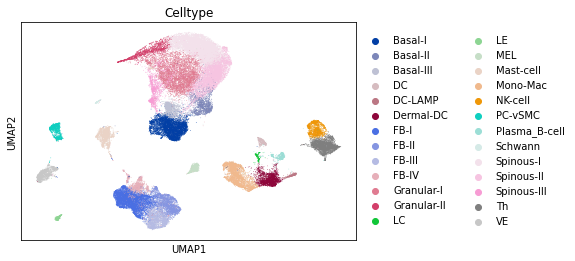

In [28]:
sc.pl.umap(adata_sc, color=['Celltype'])

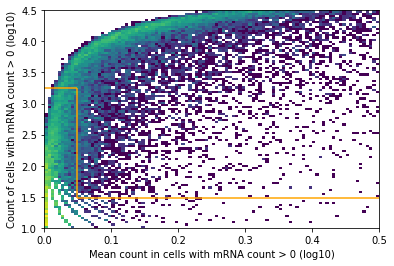

In [29]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_sc, min_genes=1)
sc.pp.filter_genes(adata_sc, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_sc.var['n_cells'] = (adata_sc.X.toarray() > 0).sum(0)
adata_sc.var['nonz_mean'] = adata_sc.X.toarray().sum(0) / adata_sc.var['n_cells']

plt.hist2d(np.log10(adata_sc.var['nonz_mean']),
           np.log10(adata_sc.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_sc.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_sc.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [30]:
# Show the number of selected cells and genes:
adata_sc[:,(np.array(np.log10(adata_sc.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff)].shape

(59880, 16530)

In [31]:
# select genes based on mean expression in non-zero cells
adata_sc = adata_sc[:,(np.array(np.log10(adata_sc.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_sc.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_sc.var['features'].isna())]

In [32]:
adata_sc

View of AnnData object with n_obs × n_vars = 59880 × 16530
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'Celltype', 'Subtype', 'MainCelltype', 'n_genes'
    var: 'features', 'n_cells', 'nonz_mean'
    uns: 'Celltype_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [41]:
# load marker genes (fc>0.5, padj<0.05)
genes = pd.read_csv(results_folder + "markergene_fc05padj05.csv")
genes = list(genes['gene'])

In [43]:
# add counts layer
adata_sc.layers["counts"] = adata_sc.X.copy()

In [44]:
# subset for the genes
adata_sc = adata_sc[:, genes].copy()

In [45]:
adata_sc

AnnData object with n_obs × n_vars = 59880 × 5267
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'Celltype', 'Subtype', 'MainCelltype', 'n_genes'
    var: 'features', 'n_cells', 'nonz_mean'
    uns: 'Celltype_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'counts'

In [46]:
# create stereoscope object
RNAStereoscope.setup_anndata(adata_sc, layer = "counts", labels_key = "Celltype")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 100/100: 100%|█████████████████████████████████████████████████████| 100/100 [29:26<00:00, 17.67s/it, loss=7.13e+05, v_num=1]


<AxesSubplot:xlabel='epoch'>

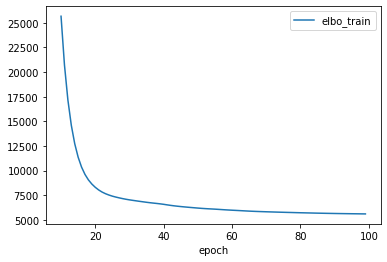

In [47]:
sc_model = RNAStereoscope(adata_sc)
sc_model.train(max_epochs = 100)
sc_model.history["elbo_train"][10:].plot()

In [59]:
ref_run_name = '/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model'
sc_model.save(f"{ref_run_name}", overwrite=True)
# rename the index (https://github.com/theislab/scvelo/issues/255), otherwise error occurs
sc_model.adata.__dict__['_raw'].__dict__['_var'] = sc_model.adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
adata_path =  os.path.join(f"{ref_run_name}","sc.h5ad")
sc_model.adata.write_h5ad(adata_path)

In [66]:
# reload sc model
ref_run_name = '/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model'

adata_path =  os.path.join(f"{ref_run_name}","sc.h5ad")
adata_sc = sc.read_h5ad(adata_path)
print("Loaded SC data from file :" + adata_path)
sc_model = RNAStereoscope.load(f"{ref_run_name}", adata_sc)
print("Loaded RNA model from file :" + ref_run_name)

Loaded SC data from file :/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model/sc.h5ad
INFO     File /Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_de
         conv/regression_model/model.pt already downloaded                                   
Loaded RNA model from file :/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv/regression_model


In [6]:
# ST data (raw counts)
adata_vis = sc.read_h5ad(results_folder + "Seurat_STseq_integrated.h5ad")

In [8]:
# OBS! The raw matrix has numericals instead of gene names as var.index, also make sure column name is correct!
adata_vis.var = adata_vis.var.drop(columns = ['_index'])
adata_vis.var.index = adata_vis.var['features']

In [9]:
adata_vis

AnnData object with n_obs × n_vars = 24712 × 36578
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Patient', 'Donor', 'Gender', 'Age', 'Seq_Batch', 'Condition', 'Sample_name', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'nFeature_noMT', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'individual_clust'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [13]:
adata_vis.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
my_array=adata_vis.X.toarray()
df=pd.DataFrame(my_array)

In [24]:
df.loc[1:20, 1:20]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# subst for same genes as sc data
genes = sc_model.adata.var_names
adata_vis.layers["counts"] = adata_vis.X.copy()
adata_vis = adata_vis[:, genes].copy()

In [72]:
adata_vis

AnnData object with n_obs × n_vars = 24712 × 5267
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'Patient', 'Donor', 'Gender', 'Age', 'Seq_Batch', 'Condition', 'Sample_name', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'nFeature_noMT', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'individual_clust'
    var: 'features'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'counts'

In [ ]:
# create object and train 
SpatialStereoscope.setup_anndata(adata_vis, layer="counts")
spatial_model = SpatialStereoscope.from_rna_model(adata_vis, sc_model)
spatial_model.train(max_epochs = 10000)
spatial_model.history["elbo_train"][10:].plot()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 5369/10000:  54%|██████████████████████                   | 5368/10000 [13:36:28<21:14:50, 16.51s/it, loss=5.87e+07, v_num=1]

In [ ]:
outdir='/Users/zhuliu/Desktop/scRNA_STseq/proj_spatialTranseq/03_results/stereoscope_deconv'
spatial_model.save(f"{outdir}/spatial_model", overwrite = True)

In [ ]:
# write results file
adata_vis.obsm["deconvolution"] = spatial_model.get_proportions()
adata_vis.obsm["deconvolution"].to_csv(outdir + "/proportions.csv")